<a href="https://colab.research.google.com/github/RobertoFernandez1/EIE_401_MULTIMEDIA/blob/main/Proyecto_2_FernandezRoberto_RobertoFernandez1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Roberto Fernandez Fuentes</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [19]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [ ]:
#Descomprimimos el arhivo.zip que contiene las imagenes con las que vamos a trabajar

import zipfile

archivo_comprimido= "/content/batch_june2024.zip"
destino = "/content/"

with zipfile.ZipFile(archivo_comprimido, 'r') as archivo_zip:
    archivo_zip.extractall(destino)

In [ ]:
#Creamos un archivo.zip aparte y lo descomprimos que de manera que podamos trabajar con el
import zipfile

archivo_comprimido = "/content/template.zip"
destino = "/content/"

with zipfile.ZipFile(archivo_comprimido, 'r') as archivo_zip:
    archivo_zip.extractall(destino)

In [ ]:
#Iniciamos un contador dentro del archivo para saber cuanto es la cantidad total de imagenes ,cuantos box ,circ o cross hay
import os

def coontador_tipo_imagenes(carpeta):

    count_circ = 0  #Inicializamos nuestros contadores en cero
    count_box = 0
    count_cross = 0


    for filename in os.listdir(carpeta): #Dentro del archivo vamos contando la cantidad de objetos de cada tipo que hay
        if filename.startswith('circ'):
            count_circ += 1 #Vamos sumando de a una imagen
        elif filename.startswith('box'):
            count_box += 1
        elif filename.startswith('cross'):
            count_cross += 1

    return count_circ, count_box, count_cross


carpeta = '/content/processed512'

count_circ, count_box, count_cross = coontador_tipo_imagenes(carpeta)
count_general=count_circ+count_box+count_cross #Suma general de todas las imagenes

print(f'Número de imágenes circle: {count_circ}')
print(f'Número de imágenes box: {count_box}')
print(f'Número de imágenes cross: {count_cross}')
print(f"Numero total de imagenes:{count_general}")



Número de imágenes circle: 4416
Número de imágenes box: 3989
Número de imágenes cross: 5923
Numero total de imagenes:14328


## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [ ]:
from PIL import Image
from torchvision import transforms
import os

# Creamos una funcion que nos permita achicar la imagen
def redimensionar_imagenes_pytorch(directorio_entrada, directorio_salida, nuevo_tamano):
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)

    transformacion = transforms.Compose([
        transforms.Resize(nuevo_tamano),
        transforms.ToTensor()
    ])

    for nombre_archivo in os.listdir(directorio_entrada):
        if nombre_archivo.endswith(('.png')):
            ruta_imagen = os.path.join(directorio_entrada, nombre_archivo)
            imagen = Image.open(ruta_imagen)

            imagen_redimensionada = transformacion(imagen)

            imagen_redimensionada_pil = transforms.ToPILImage()(imagen_redimensionada)

            ruta_salida = os.path.join(directorio_salida, nombre_archivo)
            imagen_redimensionada_pil.save(ruta_salida)
            #print(f"Imagen guardada en {ruta_salida}")

directorio_entrada = '/content/processed512'
directorio_salida = '/content/ImagenesTransformadas64x64'  # Usa una ruta absoluta para el directorio de salida
nuevo_tamano = (64, 64)  # Definimos el tamaño que tendran ahora

redimensionar_imagenes_pytorch(directorio_entrada, directorio_salida, nuevo_tamano)  # Llamamos a la funcion


In [ ]:
#Ocurria que la carpeta /content/ImagenesTransformadas64x64 se vaciaba una vez que se pasaban por la transformada wavelet ,por lo cual se duplico otra llamada
# /content/CarpetaImagenes64X64 la que no se vacia ,y nos sirve para el proceso de matching de mas adelante
import os
import shutil

def duplicar_carpeta(carpeta_origen, nueva_carpeta):
    if not os.path.exists(carpeta_origen):
        print(f"La carpeta {carpeta_origen} no existe.")
        return

    if os.path.exists(nueva_carpeta):
        print(f"La carpeta {nueva_carpeta} ya existe.")
        return

    shutil.copytree(carpeta_origen, nueva_carpeta)
    print(f"Carpeta {carpeta_origen} duplicada como {nueva_carpeta}.")

carpeta_origen = '/content/ImagenesTransformadas64x64'
nueva_carpeta = '/content/CarpetaImagenes64X64'

duplicar_carpeta(carpeta_origen, nueva_carpeta)


Carpeta /content/ImagenesTransformadas64x64 duplicada como /content/CarpetaImagenes64X64.


In [ ]:
#Trabajamos con la trasnformada wavelet de manera que el procesamiento podamos hacerlo de una manera mas rapida
import os
from PIL import Image
import pywt
import numpy as np

def apply_wavelet_transform(image):
    # Convertir la imagen a escala de grises si no lo está
    if image.mode != 'L':
        image = image.convert('L')

    image_array = np.array(image)

    # Con pywt aplicamos la transformada wavelet en las imágenes recientemente cargadas
    coeffs2 = pywt.dwt2(image_array, 'haar')
    LL, (LH, HL, HH) = coeffs2

    transformed_image = np.uint8(LL / np.max(LL) * 255)

    return Image.fromarray(transformed_image)

def procesamiento_carpeta(directorio_entrada, directorio_salida):
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)

    for filename in os.listdir(directorio_entrada):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            input_path = os.path.join(directorio_entrada, filename)
            image = Image.open(input_path)

            # Aplicar la transformada wavelet
            transformed_image = apply_wavelet_transform(image)

            output_path = os.path.join(directorio_salida, filename)
            transformed_image.save(output_path)
            #print(f"Imagen {filename} transformada y guardada en {output_path}")

# Directorios de entrada y salida
directorio_entrada = '/content/CarpetaImagenes64X64'
directorio_salida = '/content/ImagenesTransformadaWavelet'

# Procesar la carpeta
procesamiento_carpeta(directorio_entrada, directorio_salida)


In [ ]:
#Para evitar posibles errores ,vamos a duplicar la carpeta de /content/ImagenesTransformadaWavelet
import os
import shutil

def duplicar_carpeta(carpeta_origen, nueva_carpeta):
    if not os.path.exists(carpeta_origen):
        print(f"La carpeta {carpeta_origen} no existe.")
        return

    if os.path.exists(nueva_carpeta):
        print(f"La carpeta {nueva_carpeta} ya existe.")
        return

    shutil.copytree(carpeta_origen, nueva_carpeta)
    print(f"Carpeta {carpeta_origen} duplicada como {nueva_carpeta}.")

carpeta_origen = '/content/ImagenesTransformadaWavelet'
nueva_carpeta = 'ITWV'

duplicar_carpeta(carpeta_origen, nueva_carpeta)


Carpeta /content/ImagenesTransformadaWavelet duplicada como ITWV.


In [ ]:
#Dividimos la carpeta con las imagenes redimensionadas en subcarpetas donde se ordenaran segun su nombre
import shutil
import os
#Creamos una funcion para poder separar las imageness
def imagenes_separadas(folder_in, directorio_salida):
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)
    tipos_figuras = ['box', 'circ', 'cross']
    for tipo in tipos_figuras:
        carpeta_tipo = os.path.join(directorio_salida, tipo)
        os.makedirs(carpeta_tipo, exist_ok=True)

    for nombre_archivo in os.listdir(folder_in):
        if nombre_archivo.endswith('.png'):
            ruta_imagen = os.path.join(folder_in, nombre_archivo)
            #Segun el nombre vamos clasificando cada imagen
            tipo_figura = None
            if 'box' in nombre_archivo.lower():
                tipo_figura = 'box'
            elif 'circ' in nombre_archivo.lower():
                tipo_figura = 'circ'
            elif 'cross' in nombre_archivo.lower():
                tipo_figura = 'cross'


            if tipo_figura:
                carpeta_destino = os.path.join(directorio_salida, tipo_figura)
                shutil.move(ruta_imagen, os.path.join(carpeta_destino, nombre_archivo))
folder_in="/content/ImagenesTransformadaWavelet"
directorio_salida = 'Imagenes_por_box_circ_cross'  # Directorio donde se guardarán las imágenes separadas
imagenes_separadas(folder_in, directorio_salida)


## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [ ]:
#Aplicamos convolucion para la extraccion de carateristicas en la carpeta con las imagenes redimensionadas
import numpy as np
from PIL import Image
from scipy.signal import convolve2d

#Mediante esta funcion leemos la carpeta que vamos a utilizar y vamos guardando en images.append(img_array)
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            images.append(img_array)
    return images

# Realizamos la concvolucion con la carpeta de imagenes redimensionadas
def extract_features(images, kernel):
    features = []
    for img in images:
        convolved = convolve2d(img, kernel, mode='valid')
        features.append(convolved)
    return features
#Con la libreria numpy calculamos la correlacion y la vamos guardando en una matriz
def calculate_correlation(features):
    # Aplanar las características para calcular la correlación
    flattened_features = np.array([feature.flatten() for feature in features])
    correlation_matrix = np.corrcoef(flattened_features)
    return correlation_matrix
#Con lo hecho en el punto anterior vamos calculando iterando a convolucion en cada carpeta de objetos ,con tal de extraer mejor la correlacion
folder_paths = {
    'box': '/content/Imagenes_por_box_circ_cross/box',
    'circle': "/content/Imagenes_por_box_circ_cross/circ",
    'cross': '/content/Imagenes_por_box_circ_cross/cross'
}

#Kernel para los bordes
sobel_x = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])
#Guardamos la correlacion de cada imagen en esta variable
correlation_matrices = {}


for folder_name, folder_path in folder_paths.items():
    print(f"Procesando imágenes en la carpeta: {folder_name}")

    images = load_images_from_folder(folder_path)

    convolution_results = extract_features(images, sobel_x)

    correlation_matrix = calculate_correlation(convolution_results)

    correlation_matrices[folder_name] = correlation_matrix

    print(f"Matriz de correlación para {folder_name}:")
    print(correlation_matrix)
    print()
#Calculamos el promedio de cada matriz de correlacion
mean_correlation_values = {}
for folder_name, matrix in correlation_matrices.items():
    mean_value = np.mean(matrix)
    mean_correlation_values[folder_name] = mean_value

    print(f"Promedio de la matriz de correlación para {folder_name}: {mean_value}")
    print()


Procesando imágenes en la carpeta: box
Matriz de correlación para box:
[[1.         0.         0.         ... 0.13829633 0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.20114491 0.65918295 0.        ]
 ...
 [0.13829633 0.         0.20114491 ... 1.         0.31032305 0.        ]
 [0.         0.         0.65918295 ... 0.31032305 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]

Procesando imágenes en la carpeta: circle
Matriz de correlación para circle:
[[ 1.00000000e+00  2.46150868e-01 -3.75416530e-21 ...  9.86838646e-01
   3.59294587e-04  1.49403745e-01]
 [ 2.46150868e-01  1.00000000e+00  5.95050520e-21 ...  3.28434383e-01
   1.83684662e-01  9.69020521e-01]
 [-3.75416530e-21  5.95050520e-21  1.00000000e+00 ... -1.26995504e-21
  -3.11338746e-21 -8.02683308e-21]
 ...
 [ 9.86838646e-01  3.28434383e-01 -1.26995504e-21 ...  1.00000000e+00
   1.00751404e-03

## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación



Este proceso es similar a un windowing, donde la ventana es la imagen de referencia.
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [ ]:
#Vamos a ir pasando cada imagen template por todas las imagenes en la carpeta ,y de acuerdo a con cual tiene mejor correlacion se le asignara un tipo

import cv2 as cv
from timeit import default_timer as timer

start = timer()
def cargar_imagenes(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((filename, img))
            else:
                print(f"Error: No se pudo leer la imagen {img_path}")
    return images

template = '/content/template'  # Carpeta de imágenes de plantilla
imagenes = "/content/CarpetaImagenes64X64"  # Carpeta de imágenes originales

# Cargar imágenes de plantilla y de imágenes originales
templates = cargar_imagenes(template)
original_images = cargar_imagenes(imagenes)


method = cv.TM_CCOEFF_NORMED

# Guardamos lo mejor correlacion de cada imagen segun los template
best_correlations = {}

#Incializamos el contador para los errores
specific_error_count = 0

#Definimos el tamaño del batch en 1 para una mejor lectura de los datos
batch_size = 1

for start_idx in range(0, len(original_images), batch_size):
    batch_images = original_images[start_idx:start_idx + batch_size]
 #   print(f"Procesando imágenes {start_idx + 1} a {start_idx + len(batch_images)}...") Podemos ver cuantas imagenes se van procesando las imagenes

    for original_name, original_img in batch_images:
        max_correlation = -1
        best_template = None

        for template_name, template_img in templates:
            res = cv.matchTemplate(original_img, template_img, method)
            _, max_val, _, _ = cv.minMaxLoc(res)

            #Comparamos entre las 3 correlaciones segun los template ,cual es la que se ajusta mejor a la imagen
            if max_val > max_correlation:
                max_correlation = max_val
                best_template = template_name

        # Guardamos la mejor correlacion
        best_correlations[original_name] = (best_template, max_correlation)

        #contamos la cantidad de errores que tenemos entre lo que arroja la mejor correlacion y lo que deberia ser
        expected_type = original_name.split('_')[0]
        if best_template is not None and expected_type not in best_template:
            specific_error_count += 1
            end = timer()
#Mostramos por pantalla la cantidad de imagenes que llevamos procesadas ,para ver el matching uno por uno de estas quitar #
#for original_name, (best_template, max_correlation) in best_correlations.items():
 #   print(f"Para la imagen '{original_name}', la mejor plantilla es '{best_template}' con correlación {max_correlation}")




In [ ]:
#Vamos a ir pasando cada imagen template por todas las imagenes en la carpeta ,y de acuerdo a con cual tiene mejor correlacion se le asignara un tipo

import cv2 as cv
from timeit import default_timer as timer

start1 = timer()
def cargar_imagenes(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((filename, img))
            else:
                print(f"Error: No se pudo leer la imagen {img_path}")
    return images

template = '/content/template'  # Carpeta de imágenes de plantilla
imagenes = "/content/ITWV"  # Carpeta de imágenes originales

# Cargar imágenes de plantilla y de imágenes originales
templates = cargar_imagenes(template)
original_images = cargar_imagenes(imagenes)


method = cv.TM_CCOEFF_NORMED

# Guardamos lo mejor correlacion de cada imagen segun los template
best_correlations = {}

#Incializamos el contador para los errores
specific_error_count1 = 0

#Definimos el tamaño del batch en 1 para una mejor lectura de los datos
batch_size = 1

for start_idx in range(0, len(original_images), batch_size):
    batch_images = original_images[start_idx:start_idx + batch_size]
    #print(f"Procesando imágenes {start_idx + 1} a {start_idx + len(batch_images)}...")

    for original_name, original_img in batch_images:
        max_correlation = -1
        best_template = None

        for template_name, template_img in templates:
            res = cv.matchTemplate(original_img, template_img, method)
            _, max_val, _, _ = cv.minMaxLoc(res)

            #Comparamos entre las 3 correlaciones segun los template ,cual es la que se ajusta mejor a la imagen
            if max_val > max_correlation:
                max_correlation = max_val
                best_template = template_name

        # Guardamos la mejor correlacion
        best_correlations[original_name] = (best_template, max_correlation)

        #contamos la cantidad de errores que tenemos entre lo que arroja la mejor correlacion y lo que deberia ser
        expected_type = original_name.split('_')[0]
        if best_template is not None and expected_type not in best_template:
            specific_error_count1 += 1
            end1 = timer()
#Mostramos por pantalla la cantidad de imagenes que llevamos procesadas
#for original_name, (best_template, max_correlation) in best_correlations.items():
 #   print(f"Para la imagen '{original_name}', la mejor plantilla es '{best_template}' con correlación {max_correlation}")

# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


In [ ]:


#Imprimimos por pantalla la cantidad de errores y el porcentaje de acierto

#Proceso normal

print(f"Total de errores específicos encontrados: {specific_error_count}")

acierto=100*(1-(specific_error_count/count_general))

print("El porcentaje de acierto fue de un : ",acierto,"%")





Total de errores específicos encontrados: 8234
El porcentaje de acierto fue de un :  42.5321049692909 %


In [ ]:
#Descomprimimos el arhivo.zip que contiene las imagenes con las que vamos a trabajar

import zipfile

archivo_comprimido= "/content/ImagenesParte5.zip"
destino = "/content/"

with zipfile.ZipFile(archivo_comprimido, 'r') as archivo_zip:
    archivo_zip.extractall(destino)

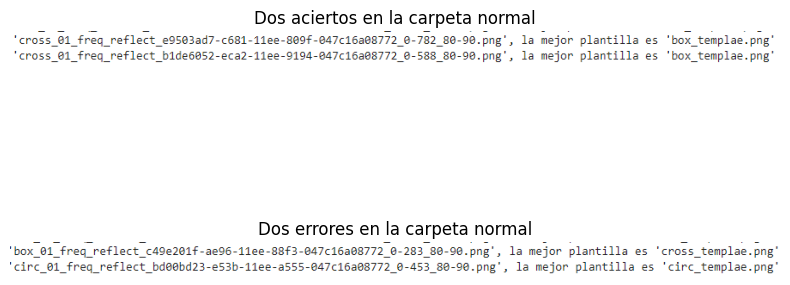

In [ ]:
import matplotlib.pyplot as plt


normal_acierto = "/content/ImagenesParte5/aciertonormal.png"
normal_error = "/content/ImagenesParte5/errornormal.png"

plt.figure(figsize=(8, 6))


plt.subplot(2, 1, 1)
img_acierto = plt.imread(normal_acierto)
plt.imshow(img_acierto)
plt.title("Dos aciertos en la carpeta normal")
plt.axis('off')

plt.subplot(2, 1, 2)
img_error = plt.imread(normal_error)
plt.imshow(img_error)
plt.title("Dos errores en la carpeta normal")
plt.axis('off')


plt.tight_layout()

plt.show()


In [ ]:
#Con wavelet
print(f"Total de errores específicos encontrados: {specific_error_count1}")

acierto=100*(1-(specific_error_count1/count_general))

print("El porcentaje de acierto fue de un : ",acierto,"%")

Total de errores específicos encontrados: 8531
El porcentaje de acierto fue de un :  40.45924064768286 %


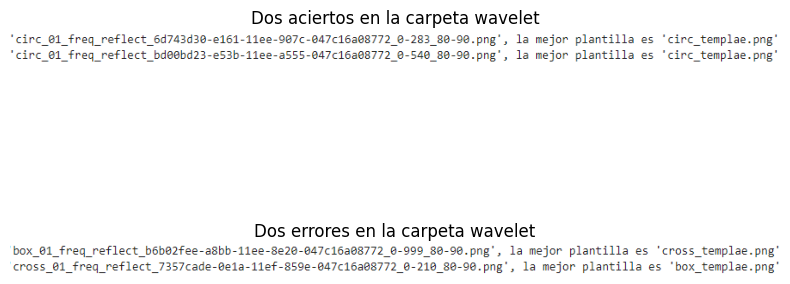

In [ ]:
import matplotlib.pyplot as plt


wavelet_acierto = "/content/ImagenesParte5/aciertowavelet.png"
wavelet_error = "/content/ImagenesParte5/errorwavelet.png"

plt.figure(figsize=(8, 6))


plt.subplot(2, 1, 1)
img_acierto = plt.imread(wavelet_acierto)
plt.imshow(img_acierto)
plt.title("Dos aciertos en la carpeta wavelet")
plt.axis('off')

plt.subplot(2, 1, 2)
img_error = plt.imread(wavelet_error)
plt.imshow(img_error)
plt.title("Dos errores en la carpeta wavelet")
plt.axis('off')


plt.tight_layout()

plt.show()

# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [ ]:
#Proceso normal
print(end - start)



4.637449107999942


In [ ]:
#Con wavelet
print(end1 - start1)

2.3853762489999326
